In [18]:
from imutils.video import VideoStream
import imutils
import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
import pandas as pd
import os
from pathlib import Path
from decimal import Decimal
from sympy import Line, Segment, Point, Eq

In [2]:
def init_data(point,t):
    data = {}
    point.append(t)
    data["points"] = [point]
    data["last_slope"] = None
    return data

def same_point(point1, point2):
    if point1[0] == point2[0] and point1[1] == point2[1]:
        return True
    if point1[0] == point2[0] and point1[1] != point2[1]:
        return None  # corresponds to infinite slope
    else:
        return False
    
def average_point(point1, point2):
    return [(point1[0] + point2[0])/2, (point1[1] + point2[1])/2, point2[2]] 

In [3]:
def get_slope(point1, point2):
    return (point1[1]-point2[1])/(point1[0]-point2[0])

def proximity(point1, point2, R=150):
    if (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 <= R**2:
        return True
    else:
        return False
    
def time_continuity(time1, point):
    time2 = point[-1]
    if time1 == time2:
        return None
    if time1 - time2 <= 3 and time1 - time2 > 0:
        return True
    else:
        return False
    
def add_time(point, t):
    if len(point) == 2:
        point.append(t)

In [4]:
def update_line(point, data,t):
    """
    Returns the updated line (data) with all the points and last slope. If the point does not lie within this 
    "band" then returns the unchanged line (data)
    """
    list_of_previous_points = data["points"]
    last_slope = data["last_slope"]
    last_point = list_of_previous_points[-1]
    initial_point = list_of_previous_points[0]

    if proximity(point, last_point) is True:  # point is in close proximity
        if len(list_of_previous_points) >= 2:
            if same_point(point, last_point) is False:
                    if time_continuity(t, last_point) is None:
                        list_of_previous_points[-1] = average_point(point, last_point)  # honestly, I should check the slopes here as well no?
                        #data["points"] = list_of_previous_points
                        
                    if time_continuity(t, last_point) is True:
                        slope_to_test = get_slope(point, last_point)
                        if same_point(point, initial_point) is False:
                            slope_init = get_slope(point, initial_point)
                            if check_slope(slope_init, last_slope, slope_to_test) is True:
                                #print("passed constraints")
                                add_time(point,t)
                                list_of_previous_points.append(point)
                                # update dict
                                #data["points"] = list_of_previous_points
                                data["last_slope"] = slope_to_test

            if same_point(point, last_point) is True:
                add_time(point,t)
                list_of_previous_points.append(point)
                #data["points"] = list_of_previous_points

        if len(list_of_previous_points) == 1:
            if same_point(point, initial_point) is False:
                if time_continuity(t,initial_point) is True:
                    slope = (point[1]-initial_point[1])/(point[0]-initial_point[0])
                    # update dict
                    data["last_slope"] = slope
                    add_time(point,t)
                    list_of_previous_points.append(point)
                if time_continuity(t, initial_point) is None:
                    list_of_previous_points[0] = average_point(point,initial_point)

            if same_point(point, initial_point) is True:
                if time_continuity(t,initial_point) is True:
                    add_time(point,t)
                    list_of_previous_points.append(point)       
            
            #data["points"] = list_of_previous_points
    
    return data
            
        
def check_slope(slope1, slope2, slope3, slope_error=1):
    """
    checks if slope3 is similar to slopes 2 and 1.   
    """
    if slope2 is None:
        if abs(slope1 - slope3) <= slope_error:
            return True
    if slope2 is not None:
        if abs(slope1 - slope3) <= slope_error and abs(slope2 - slope3) <= slope_error:
            return True
    else:
        return False

In [5]:
def check_for_lines(datas,point, t):
    if bool(datas) is False:  # no data points yet
        data = init_data(point,t)
        datas.append(data)
    else:
        count = 0  # used to keep in memory the amount of times a point was part of a line
        for i in range(len(datas)):
            line = copy.deepcopy(datas[i])
            new_line = datas[i]
            update_line(point,new_line,t)  
            if line != new_line:
                count += 1
                
        if count == 0: # the point didn't correspond to any existing line
            data = init_data(point,t)
            datas.append(data)  # create a new line

    return datas

In [6]:
def to_unit_vector(point, width=1080, height=1920 , AOV=np.radians(39.23)):
    """
    y points through the screen and x points right (CCW motion). Point is in cols, rows.
    Output corresponds to rows, cols.
    """
    distance_to_screen = np.sqrt(Decimal((width**2+height**2)))/Decimal(2*np.tan(AOV))
    vector = np.array((Decimal(point[0]-height/2), distance_to_screen, Decimal(width/2-point[1]), point[2]))
    #print("vector in px", vector)
    vector[:-1] = vector[:-1]/np.linalg.norm(vector[:-1])
    return vector


In [7]:
def get_meas(datas):
    datas_new = copy.deepcopy(datas)
    set_of_meas = []
    for dict in datas:
        if len(dict["points"]) <= 15:
            datas_new.remove(dict)
        else:
            line=[]
            for point in dict["points"]:
                new_point = to_unit_vector(point)
                line.append(new_point)
            set_of_meas.append(line)
    return set_of_meas
    

In [8]:
datas = []
datas_KNN = []
datas_MOG = []
directory = "Earth"

#Method 1

In [9]:
for filename in os.listdir(directory):
    video_location = directory + "/"+ filename
    print(video_location)
    vs = cv2.VideoCapture(video_location)
    # initialize the first frame in the video stream
    avg = None
    # initialise data on debris lines
    lines = []
    #main body
    accumulated_thresh = np.zeros((1080,1920))
    t=0
    while True:
        frame = vs.read()
        frame = frame[1]
        text = "unoccupied"
        
        # if the frame could not be grabbed, then we have reached the end
        # of the video
        if frame is None:
            break
        
        # resize the frame, convert it to grayscale, and blur it
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)

        # if the first frame is None, initialize it
        if avg is None:
            avg = gray.copy().astype("float")
            continue

        # compute the absolute difference between the current frame and
        # first frame
        cv2.accumulateWeighted(gray, avg, 0.75)
        frameDelta = cv2.absdiff(gray, cv2.convertScaleAbs(avg))
        thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]

        # dilate the thresholded image to fill in holes, then find contours
        # on thresholded image
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        # save the contours into an accumulated thresh image
        accumulated_thresh = cv2.accumulate(thresh, accumulated_thresh)

        # loop over the contours
        for c in cnts:
            if cv2.contourArea(c) > 20:
            # compute the bounding box for the contour, draw it on the frame,
            # and update the text
            
                (x, y, w, h) = cv2.boundingRect(c)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
                #ellipse = cv2.fitEllipse(c)
                #cv2.ellipse(frame,ellipse,(0,255,0),2)
                text = "Occupied"
                # get the location of the centroid
                M = cv2.moments(c)
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                #print("-------------------------------")
                #print([cx,cy], t)  # cols, rows 
                lines = check_for_lines(lines, [cx,cy],t)  

        cv2.imshow("Satellite Feed", frame)
        cv2.imshow("thresh", thresh)
        cv2.waitKey(0)
        t+=1

    datas.append(lines)
    measurements_M1 = get_meas(lines)
    cv2.destroyAllWindows()


Earth/data_0_0.avi


In [48]:
%store measurements_M1

Stored 'measurements_M1' (list)


#Method 2

In [50]:
# KNN
backSub = cv2.createBackgroundSubtractorKNN(history=15, dist2Threshold=400, detectShadows=False)

In [51]:
for filename in os.listdir(directory):
    video_location = directory + "/"+ filename
    print(video_location)
    vs = cv2.VideoCapture(video_location)
    # initialize the first frame in the video stream
    avg = None
    # initialise data on debris lines
    lines = []
    t = 0

    while True:
        ret, frame = vs.read()
        if frame is None:
            break

        fgMask = backSub.apply(frame)

        thresh = cv2.dilate(fgMask, None, iterations=2)  # makes bright regions grow
        cnts = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        # loop over the contours
        for c in cnts:
            if cv2.contourArea(c) > 20:
                # compute the bounding box for the contour, draw it on the frame
                (x, y, w, h) = cv2.boundingRect(c)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                #text = "Occupied"
                #ellipse = cv2.fitEllipse(c)
                #cv2.ellipse(frame,ellipse,(0,255,0),2)
                text = "Occupied"
                # get the location of the centroid
                M = cv2.moments(c)
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                #print("-------------------------------")
                #print([cx,cy], t)  # cols, rows 
                lines = check_for_lines(lines, [cx,cy],t)
        #cv2.rectangle(frame, (10, 2), (100, 20), (255, 255, 255), 1)
    
        #cv2.imshow('Frame', frame)
        #cv2.imshow('Thresh', thresh)
        #cv2.imshow('FG Mask', fgMask)
        t+=1
        #cv2.waitKey(0)
    datas_KNN.append(lines)
    measurements_M2 = get_meas(lines)
    cv2.destroyAllWindows()

Earth/data_0_0.avi


In [52]:
%store measurements_M2

Stored 'measurements_M2' (list)


#Method 3

In [15]:
# MOG2
backSub = cv2.createBackgroundSubtractorMOG2(history=15, varThreshold=16, detectShadows=False)

In [16]:
for filename in os.listdir(directory):
    video_location = directory + "/"+ filename
    print(video_location)
    vs = cv2.VideoCapture(video_location)
    # initialize the first frame in the video stream
    avg = None
    # initialise data on debris lines
    lines = []
    t = 0
    last_time = 0
    last_point = None
    while True:
        ret, frame = vs.read()
        if frame is None:
            break

        fgMask = backSub.apply(frame)  # update background model

        thresh = cv2.dilate(fgMask, None, iterations=4)  # makes bright regions grow
        cnts = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        # loop over the contours
        for c in cnts:
            if cv2.contourArea(c) > 20:
                # compute the bounding box for the contour, draw it on the frame
                (x, y, w, h) = cv2.boundingRect(c)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                #text = "Occupied"
                #ellipse = cv2.fitEllipse(c)
                #cv2.ellipse(frame,ellipse,(0,255,0),2)
                text = "Occupied"
                # get the location of the centroid
                M = cv2.moments(c)
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                #print("-------------------------------")
                point = [cx,cy]
                print("why", t - last_time)
                if t - last_time == 1:
                    if cx - last_point[0] != 0:
                        slope = (cy - last_point[1])/(cx - last_point[0])
                        print("slope", slope)
                    else:
                        print("inf slope")
                    
                
                last_point = point
                print([cx,cy], t)  # cols, rows 
                lines = check_for_lines(lines, [cx,cy],t)
        #cv2.rectangle(frame, (10, 2), (100, 20), (255, 255, 255), 1)
    
        #cv2.imshow('Frame', frame)
        #cv2.imshow('Thresh', thresh)
        #cv2.imshow('FG Mask', fgMask)
        last_time = t
        t+=1
        cv2.waitKey(0)
    
    datas_MOG.append(lines)
    measurements_M3 = get_meas(lines)
    cv2.destroyAllWindows()

Earth/data_0_0.avi
why 0
[959, 539] 0
why 1
slope -0.5444801714898178
[26, 1047] 3
why 1
slope -0.38461538461538464
[39, 1042] 4
why 1
slope -0.6666666666666666
[51, 1034] 5
why 1
slope -0.5454545454545454
[62, 1028] 6
why 1
slope -0.5
[74, 1022] 7
why 1
slope -0.5454545454545454
[85, 1016] 8
why 1
slope -0.5833333333333334
[97, 1009] 9
why 1
slope -0.5454545454545454
[108, 1003] 10
why 1
slope -0.1679506933744222
[1406, 785] 10
why 1
slope -2.8
[1501, 519] 10
why 1
slope -3.75
[1505, 504] 10
why 1
slope 0.1480978260869565
[769, 395] 10
why 1
slope -0.9275808936825886
[120, 997] 11
why 1
slope -0.6
[130, 991] 12
why 1
slope -0.5
[142, 985] 13
why 1
slope -0.631578947368421
[161, 973] 14
why 1
slope -0.25
[165, 972] 15
why 1
slope -0.5454545454545454
[176, 966] 16
why 1
slope -0.5454545454545454
[187, 960] 17
why 1
slope -0.5384615384615384
[200, 953] 18
why 1
slope -0.6
[210, 947] 19
why 1
slope 0.11068211068211069
[987, 1033] 20
why 1
slope 0.5862068965517241
[958, 1016] 20
why 1
slop

In [55]:
%store measurements_M3

Stored 'measurements_M3' (list)


Data analysis

In [62]:
get_meas(datas_MOG[0], "test_def")

In [ ]:
xs=[]
ys=[]
for point in datas_new[0]["points"]:
    xs.append(point[0])
    ys.append(point[1])

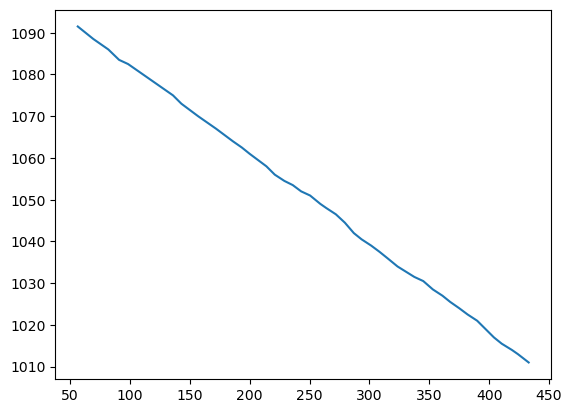

In [ ]:
plt.plot(ys,xs)

Ideal case

In [29]:
%store -r all_coordinates

In [8]:
%store -r all_rel

In [30]:
for dict1 in all_coordinates:
    i = 0
    new_list = []
    for point in dict1["pixels"]:
        new_point = to_unit_vector(point)
        new_list.append(new_point)
    dict1.update({"from pixels":new_list})

In [31]:
%store all_coordinates

Stored 'all_coordinates' (list)


In [31]:
%store -r orbits